본 ipynb 파일은 초기 제공 코드를 한국어 주석만 추가하고 분석한 파일로, 원본 파일이 더 자세히 적혀있고 의역이 있을 수 있다.

원본 파일 : ch3_nb1_discover_cnns_basic_ops.ipynb

텐서플로 2로 합성곱, 평균 풀링, 최대 풀링 계층을 사용하는 방법을 배운다.

In [ ]:
%matplotlib inline
# !pip install scikit-image   # 설치할려면 주석 해제
# !pip install matplotlib     # 설치할려면 주석 해제
import tensorflow as tf
import matplotlib
from matplotlib import pyplot as plt
from skimage import io        # 이미지 로딩을 위함

## Setup

예제로 사용할 이미지를 로딩한다.

In [ ]:
image = io.imread("./res/bird_pic_by_benjamin_planche.png")

Image shape: (680, 608)


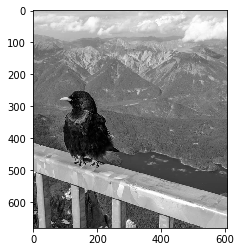

In [ ]:
print("Image shape: {}".format(image.shape))
plt.imshow(image, cmap=plt.cm.gray)

이미지를 TensorFlow에 적용하기 위해 Tensor 형태로 변환한다.

In [ ]:
image = tf.convert_to_tensor(image, tf.float32, name="input_image")

대다수의 데이터 로딩 방식 상, Batch size를 설정하여 (Batch_size, Height, Width, Channel)의 형태로 데이터를 로딩하므로, 여기서도 비슷한 형태로 차원을 하나 더 만들어주도록 한다.

In [ ]:
image = tf.expand_dims(image, axis=0) # we expand our tensor, adding a dimension at position 0


추가로, 이미지의 채널 수(RGB)에 따라 마지막 텐서의 크기를 조절해줘야 하는데, 본 예제는 흑백 이미지 이므로 제일 마지막 Channel 개수를 1로 설정해준다.

In [ ]:
image = tf.expand_dims(image, axis=-1) # we expand our tensor, adding a dimension at position 0
print("Tensor shape: {}".format(image.shape))

Tensor shape: (1, 680, 608, 1)


## Convolution

Convolution에 대한 개념은 다음 [링크](https://yjs-program.tistory.com/139//)에 정리해두었으니 참고해도 좋다.


2장에서 설명한 것처럼 TensorFlow에서 이미지 컨볼루션의 기본 방법은 tf.nn.conv2()입니다. 이 장의 그림 3과 4를 재현하는 데 사용할 것입니다.

그림3처럼
블러 처리(가우시안 블러)에 많이 사용되는  3x3 filter를 적용하도록 하였다.

그림 3

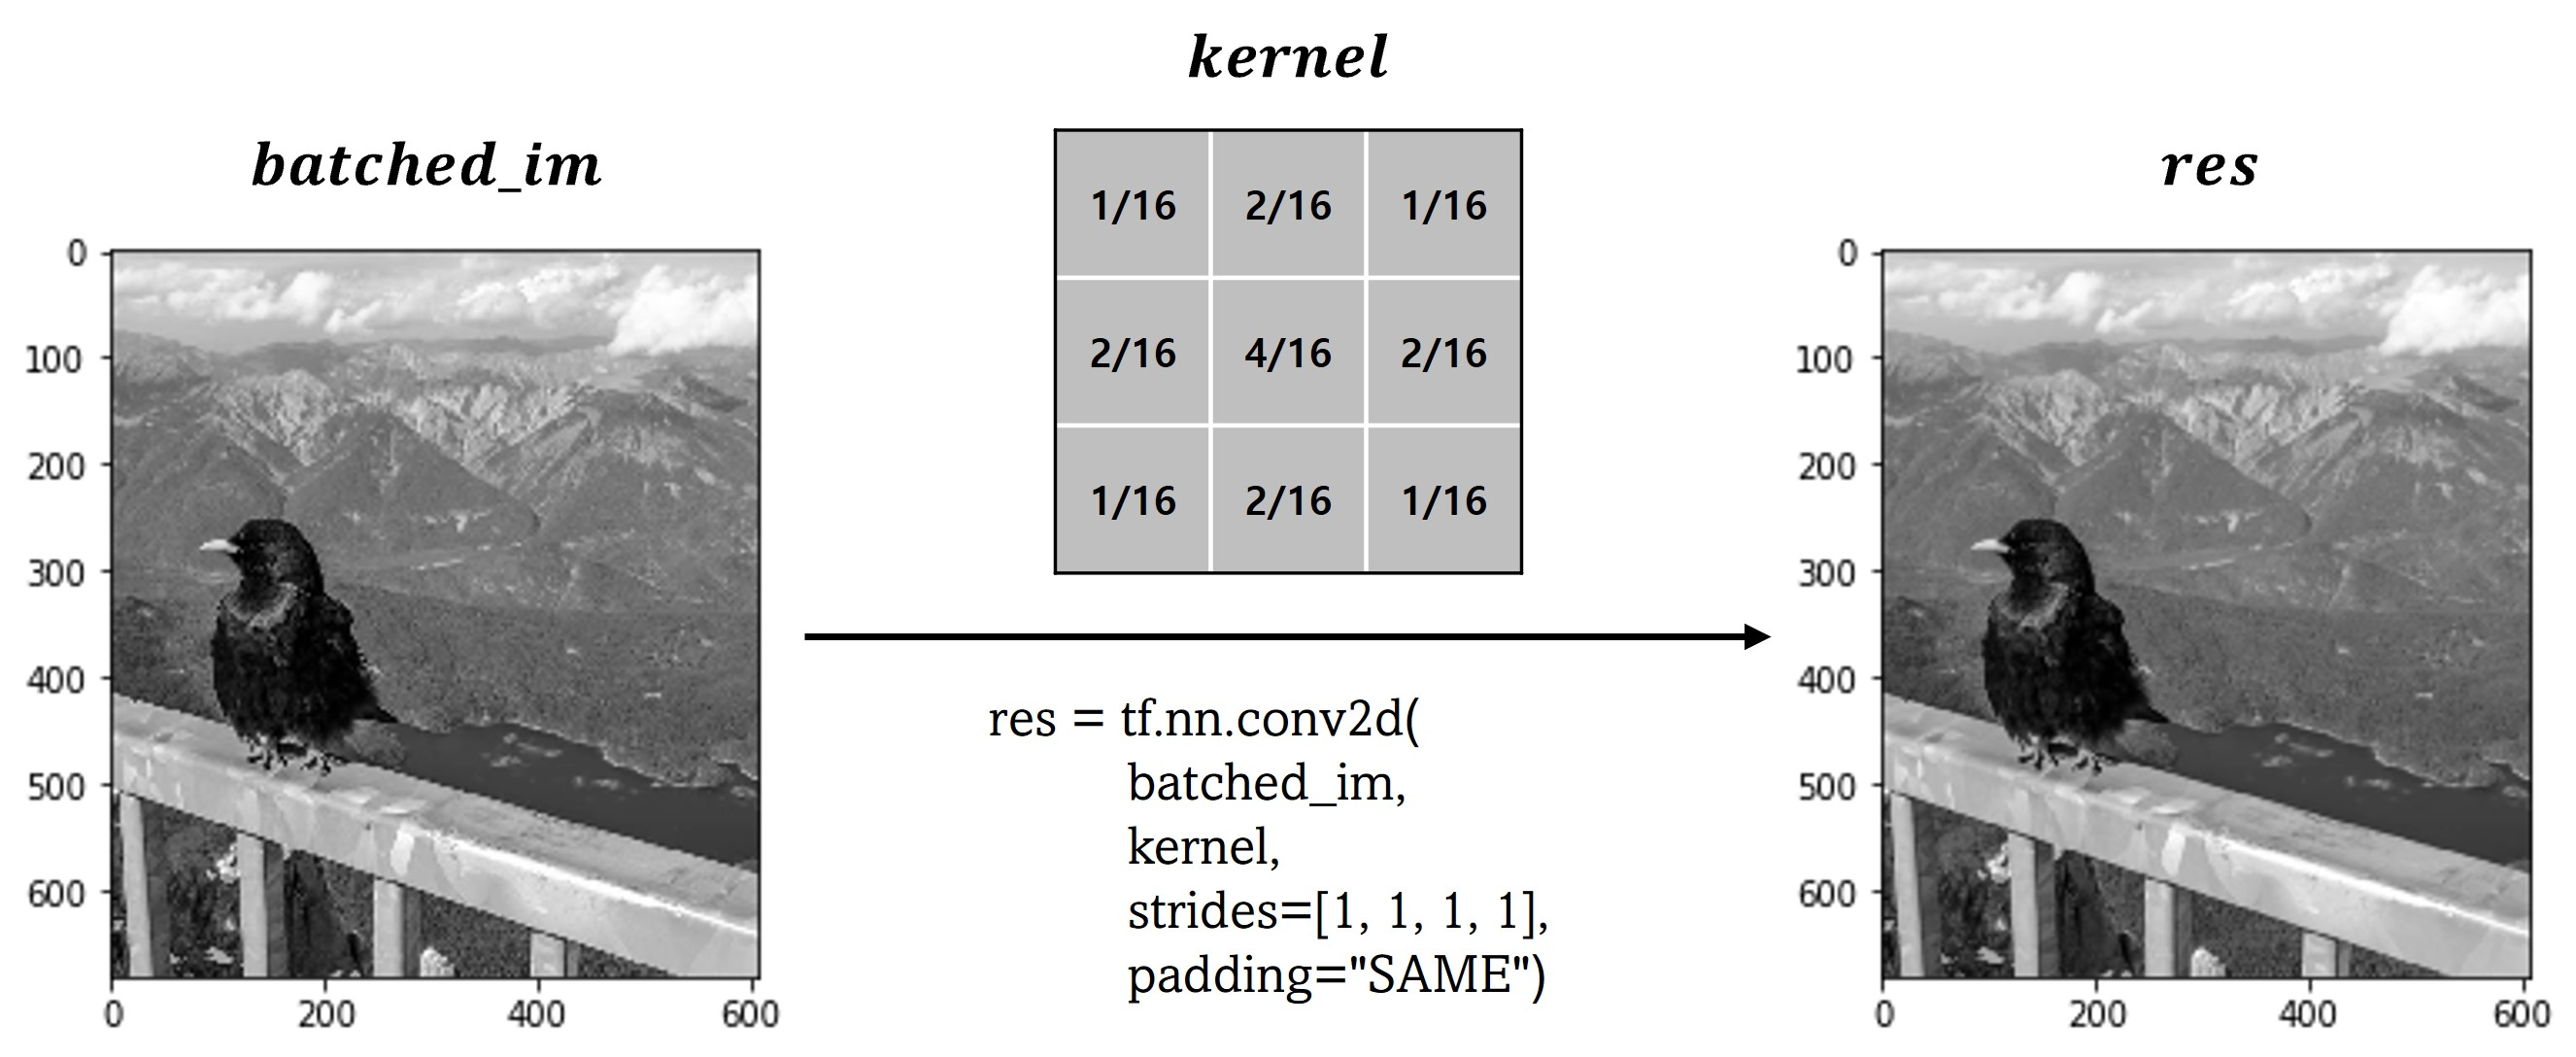

In [ ]:
kernel = tf.constant([[1 / 16, 2 / 16, 1 / 16],
                      [2 / 16, 4 / 16, 2 / 16],
                      [1 / 16, 2 / 16, 1 / 16]], tf.float32, name="gaussian_kernel")


그러나 컨볼루션 방법을 사용하려면 필터 텐서의 모양이$(k, k, D, N)$이어야 합니다(정사각형 필터의 경우 필터 크기는 k이고 필터 수는 N임). 우리의 경우 D=1 및 N=1이지만 이러한 값을 명시적으로 표현하기 위해 커널을 재구성해야 합니다.

In [ ]:
kernel = tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)

커널로 이미지 필터링을 진행하려면 tf.nn.Conv2d()를 호출해주면 된다.

In [ ]:
blurred_image = tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], padding="SAME")

By default in _eager_ mode with TensorFlow 2, we can directly recover the result of the operation:

Tensorflow 2에서는 바로 결과물을 복구해볼 수 있다.

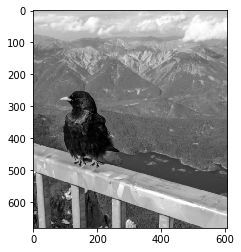

In [ ]:
blurred_res = blurred_image.numpy()
# We "unbatch" our result by selecting the first (and only) image; we also remove the depth dimension:
blurred_res = blurred_res[0, ..., 0]

plt.imshow(blurred_res, cmap=plt.cm.gray)

새의 깃털이나 주변 배경을 보면 약간 흐릿해진 모습을 볼 수 있다.

그림 4에서는 컨투어(윤곽 검출)을 위해 다음과 같은 커널을 설정해준다.

그림 4



In [ ]:
kernel = tf.constant([[-1, -1, -1],
                      [-1,  8, -1],
                      [-1, -1, -1]], tf.float32, name="edge_kernel")
kernel = tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)

This time, we use a larger stride to demonstrate how this affects the resulting tensors:

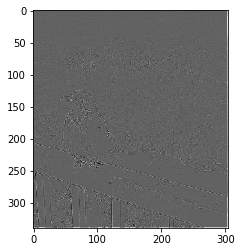

In [ ]:
edge_image = tf.nn.conv2d(image, kernel, strides=[1, 2, 2, 1], padding="SAME")
edge_res = edge_image.numpy()[0, ..., 0]
plt.imshow(edge_res, cmap=plt.cm.gray)

If you look closely, the image has a white border. This is caused by the zero-padding (since we chose padding `"SAME"`), detected as a contour by the kernel. Indeed, it disappears if we don't pad the image:

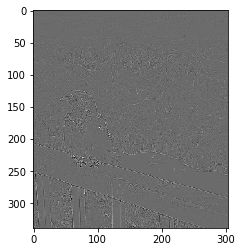

In [ ]:
edge_image = tf.nn.conv2d(image, kernel, strides=[1, 2, 2, 1], padding="VALID")
edge_res = edge_image.numpy()[0, ..., 0]
plt.imshow(edge_res, cmap=plt.cm.gray)

## Pooling

For ***max-pooling*** and ***average-pooling***, the values in each window are aggregated into a single output, applying respectively the max or averaging operation. Once again, we use the low-level TensorFlow API to reproduce the results shown in the chapter:

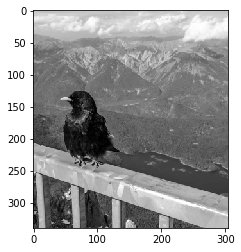

In [ ]:
avg_pooled_image = tf.nn.avg_pool(image, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
avg_res = avg_pooled_image.numpy()[0, ..., 0]
plt.imshow(avg_res, cmap=plt.cm.gray)

With these _hyper-parameters_, the average pooling divided each dimension of the input image by 2.

Now performing the max-pooling:

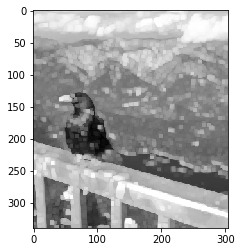

In [ ]:
max_pooled_image = tf.nn.max_pool(image, ksize=[1, 10, 10, 1], strides=[1, 2, 2, 1], padding="SAME")
max_res = max_pooled_image.numpy()[0, ..., 0]
plt.imshow(max_res, cmap=plt.cm.gray)

Using an excessively large kernel size, we can see how the operation assignes the largest value per window. 

### Conclusion

Adding these operations to the fully-connected layer presented earlier, we now have the tools to build our first CNN - which will be the topic of the next notebook.